In [7]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GRU
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report


In [8]:
# Завантаження датасету
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_csv(url, sep='\t', header=None, names=['label', 'text'])

print(df.head())

  label                                               text
0   ham  Go until jurong point, crazy.. Available only ...
1   ham                      Ok lar... Joking wif u oni...
2  spam  Free entry in 2 a wkly comp to win FA Cup fina...
3   ham  U dun say so early hor... U c already then say...
4   ham  Nah I don't think he goes to usf, he lives aro...


In [9]:
# Перетворюємо мітки у числа
le = LabelEncoder()
df['label_num'] = le.fit_transform(df['label'])  # ham=0, spam=1

texts = df['text'].values
labels = df['label_num'].values

# Параметри токенізації
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
X = pad_sequences(sequences, maxlen=max_len)
y = labels

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
model_random = Sequential([
    Embedding(input_dim=max_words, output_dim=100, input_length=max_len),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_random.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_random.summary()

C:\Users\Nuts1k\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [11]:
history_random = model_random.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=6,
    batch_size=64,
    verbose=1
)

Epoch 1/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step - accuracy: 0.8948 - loss: 0.3254 - val_accuracy: 0.9675 - val_loss: 0.1634
Epoch 2/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9820 - loss: 0.0816 - val_accuracy: 0.9798 - val_loss: 0.0717
Epoch 3/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9907 - loss: 0.0304 - val_accuracy: 0.9832 - val_loss: 0.0771
Epoch 4/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 0.9964 - loss: 0.0140 - val_accuracy: 0.9854 - val_loss: 0.0682
Epoch 5/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9992 - loss: 0.0058 - val_accuracy: 0.9843 - val_loss: 0.0773
Epoch 6/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9997 - loss: 0.0030 - val_accuracy: 0.9843 - val_loss: 0.0857


In [12]:
# Оцінка
y_pred_random = (model_random.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred_random, target_names=['ham', 'spam']))

35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 
              precision    recall  f1-score   support

         ham       0.99      1.00      0.99       966
        spam       0.98      0.94      0.96       149

    accuracy                           0.99      1115
   macro avg       0.98      0.97      0.98      1115
weighted avg       0.99      0.99      0.99      1115



In [14]:
import requests, zipfile, io

# Завантажуємо архів GloVe
url = "http://nlp.stanford.edu/data/glove.6B.zip"
print("Завантаження GloVe embeddings...")

r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))
z.extractall("glove")
print("✅ GloVe успішно розпаковано в папку 'glove'")

Завантаження GloVe embeddings...
✅ GloVe успішно розпаковано в папку 'glove'


In [15]:
embeddings_index = {}
with open('glove/glove.6B.100d.txt', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors.")

Loaded 400000 word vectors.


In [16]:
embedding_dim = 100
word_index = tokenizer.word_index
embedding_matrix = np.zeros((max_words, embedding_dim))

for word, i in word_index.items():
    if i < max_words:
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [17]:
model_glove = Sequential([
    Embedding(input_dim=max_words,
              output_dim=embedding_dim,
              weights=[embedding_matrix],
              input_length=max_len,
              trainable=False),
    LSTM(64, dropout=0.3, recurrent_dropout=0.3),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_glove.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_glove.summary()

C:\Users\Nuts1k\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)              │ ?                           │       1,000,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,000,000 (3.81 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 1,000,000 (3.81 MB)

In [18]:
history_glove = model_glove.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=6,
    batch_size=64,
    verbose=1
)

Epoch 1/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 42ms/step - accuracy: 0.8881 - loss: 0.2903 - val_accuracy: 0.9518 - val_loss: 0.1451
Epoch 2/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9520 - loss: 0.1310 - val_accuracy: 0.9697 - val_loss: 0.0996
Epoch 3/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9683 - loss: 0.0981 - val_accuracy: 0.9720 - val_loss: 0.0989
Epoch 4/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - accuracy: 0.9691 - loss: 0.1024 - val_accuracy: 0.9731 - val_loss: 0.0845
Epoch 5/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 3s 32ms/step - accuracy: 0.9734 - loss: 0.0810 - val_accuracy: 0.9686 - val_loss: 0.0850
Epoch 6/6
56/56 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.9728 - loss: 0.0769 - val_accuracy: 0.9742 - val_loss: 0.0815


In [19]:
# Оцінка
y_pred_glove = (model_glove.predict(X_test) > 0.5).astype("int32")
print(classification_report(y_test, y_pred_glove, target_names=['ham', 'spam']))


35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step 
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99       966
        spam       0.93      0.94      0.93       149

    accuracy                           0.98      1115
   macro avg       0.96      0.96      0.96      1115
weighted avg       0.98      0.98      0.98      1115



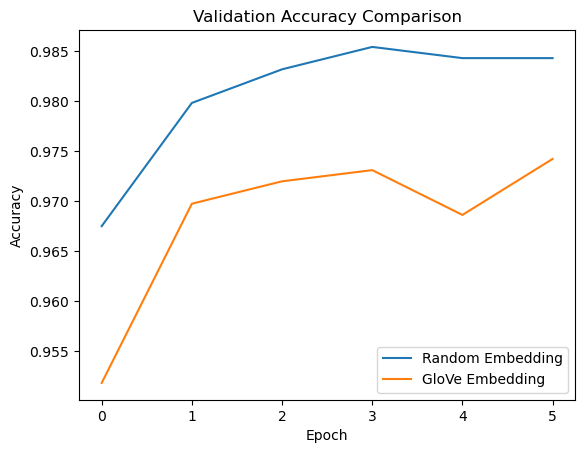

In [20]:
import matplotlib.pyplot as plt

plt.plot(history_random.history['val_accuracy'], label='Random Embedding')
plt.plot(history_glove.history['val_accuracy'], label='GloVe Embedding')
plt.title('Validation Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
